# Exploring last.fm library with Python and Plotly

I suffer from a self-diagnosed light version of OCD and I generaylly take too much pleasure in kepin track of the things I do - be it work or leisure. So it should come as no surprise that I track which books I read on Goodreads, or what music I listen to on last.fm. In this post I'll explore my music library scrapped from the latter.  

### Scrapping and tidying the data
Frustraitingly enough, last.fm doesn't offer a built-in faeture for exporting your data, so here's a handy python [script](https://gist.github.com/anamariaelek/7d267871fd09ee7ee1380960fb83a732) to do that. Call it with the username argument (`-u`) to get all of the scrobbles from the user's library in the output `csv` file (`-o`).

In [1]:
#%%bash
#lastexport.py -u anamariaelek -o exported_data.csv

The script could also be called with `-t` argument set to `loved` or `banned` to retrieve those tracks (the default value is `scrobbles`).

In [2]:
#%%bash
#lastexport.py -u anamariaelek -t loved -o exported_loved.csv

Next thing, import the data in Python.

In [3]:
import pandas as pd
data = pd.read_csv("exported_data.csv", usecols=[0,1,2,3], \
                   names=['DateTime','Song','Artist','Album'], \
                   header=None, sep='\t', engine='python')
data.head()

,DateTime,Song,Artist,Album
0,"31 Oct 2017, 23:47",Aerial Ocean,The Pines,Above the Prairie
1,"31 Oct 2017, 23:43",Better Days,Old Sea Brigade,Old Sea Brigade
2,"31 Oct 2017, 23:40",Tidal Wave,Old Sea Brigade,Cover My Own EP
3,"31 Oct 2017, 23:36",Home,Craig Gallagher,Home - EP
4,"31 Oct 2017, 23:32",Someone to Stay,Vancouver Sleep Clinic,NaN


A handy summary of the data:

In [4]:
data.describe()

,DateTime,Song,Artist,Album
count,74394,74394,74394,71036
unique,74394,7342,582,1517
top,"14 Nov 2017, 01:23",Ghosts That We Knew,The Proclaimers,Sunshine On Leith
freq,1,201,7039,1345


Now let's tidy this a little bit.  

I need to convert the `DateTime` column to appropriate `datetime` format (note here `infer_datetime_format=True` argument which speeds things up!)  

In [5]:
datetime = pd.to_datetime(data.DateTime,infer_datetime_format=True)
datetime.sort_values().describe()

count                   74394
unique                  74394
top       2019-02-02 03:06:00
freq                        1
first     1970-01-01 00:00:00
last      2019-02-03 22:25:00
Name: DateTime, dtype: object

Notice that the oldest date is 01. Jan 1970, otherwise known as the begining of [Unix or POSIX time](https://en.wikipedia.org/wiki/Unix_time). I certainly didn't listen to any music back then (as I wasn't even born at the time) so this indicates there are some in my library which are missing date and time information. Upon inspection, there are only two of them (out of 75k total scrobbles), and sure thing, I will just filter them out. 

In [6]:
data.DateTime = datetime
data[data.DateTime<"2014"]
data = data[data.DateTime>="2014"]

I'll also load the loved tracks data, while I'm at it.

In [7]:
loved = pd.read_csv("loved_data.csv", usecols=[0,1,2], \
                    names=['DateTime','Song','Artist'], \
                    header=None, sep='\t', engine='python')
loved.head()
datetimeloved = pd.to_datetime(loved.DateTime,infer_datetime_format=True)
datetimeloved.sort_values().describe()

count                     635
unique                    495
top       2014-03-01 13:18:00
freq                        9
first     2014-03-01 11:14:00
last      2019-02-01 18:36:00
Name: DateTime, dtype: object

### Inspecting the data
Let's now inspect the data further. Here are my top artists and most played songs.

In [8]:
# artists
artists_scrobbles = data.groupby("Artist").count().reset_index()[['Artist','Song']]
artists_scrobbles.rename(columns={'Song':'ArtistScrobbles'}, inplace=True)
asdf = artists_scrobbles.sort_values(by=['ArtistScrobbles'], ascending=False)
asdf.head()

,Artist,ArtistScrobbles
521,The Proclaimers,7039
560,U2,3977
147,Dropkick Murphys,3950
162,Eros Ramazzotti,3025
331,Mumford & Sons,2140


In [9]:
# songs
scrobbles = data.groupby("Song").count().reset_index()[['Song','Artist']]
scrobbles.rename(columns={'Artist':'SongScrobbles'}, inplace=True)
songs = data[['Song','Artist']].drop_duplicates()
songs_scrobbles = pd.merge(scrobbles, songs, on="Song", how="left")[['Song','Artist','SongScrobbles']]
ssdf = songs_scrobbles.sort_values(by=['SongScrobbles'], ascending=False)
ssdf.head()

,Song,Artist,SongScrobbles
2303,Ghosts That We Knew,Mumford & Sons,201
5973,Sunshine On Leith,The Proclaimers,194
5289,Saturn,Sleeping at Last,158
5648,Solo Ieri,Eros Ramazzotti,151
3822,Love Is a Laserquest,Arctic Monkeys,138


But this is something you can see in the web browser, anyway. I want to explore my data a little bit differently, and first, I'll look at the distribution of played songs for the artists I listened to most often.

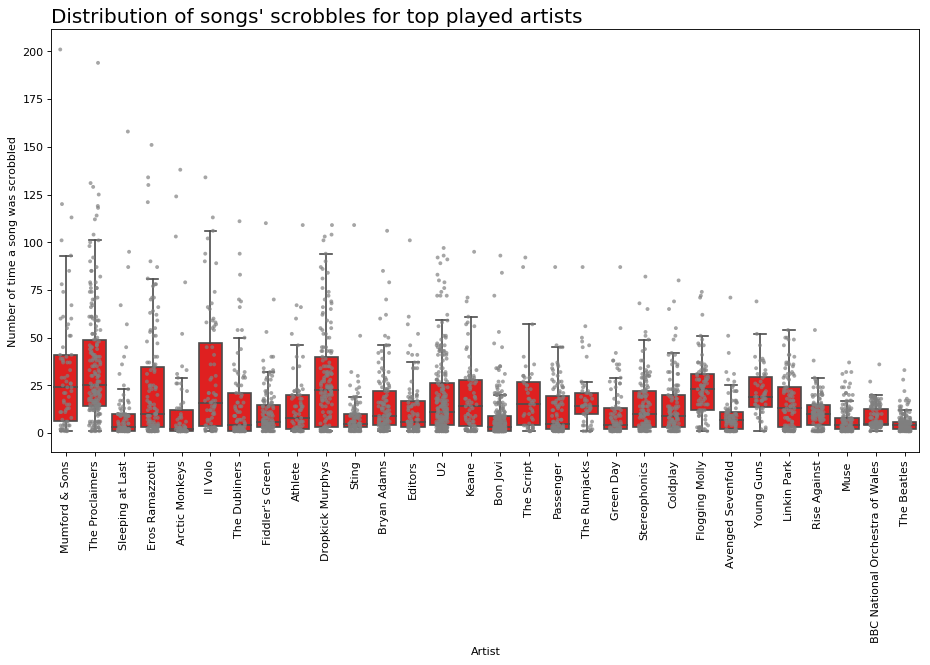

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

snsboxdata = ssdf[ssdf.Artist.isin(asdf.Artist.head(30))]

palette = plt.get_cmap('Set1')
fig = plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')    
ax = sns.boxplot(x='Artist', y='SongScrobbles', data=snsboxdata, showfliers=False, color='r')
ax = sns.stripplot(x='Artist', y='SongScrobbles', data=snsboxdata, color='grey', jitter=0.2, size=3.5, alpha=0.7)

plt.title('Distribution of songs\' scrobbles for top played artists', loc="left", fontsize=18)
plt.ylabel('Number of time a song was scrobbled')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()

Broadly speaking thare is no strong shift in the distribution of scrobbles for songs by different artists - this is no surprise to me, since I try to listen to as many songs by any artist I like, which ultimately leads to the fact that the distribution of plays spans the range from one or a few (for the songs I didn't particularly like) to about 100 or more plays (for the songs which I *really* liked and often listened to).  
  
What's interesting to see, however, is the IQR for the artists in the top (i.e. left) half of the plot. The ones with the wide IQR are actually my real favourites, because I listened to many of their songs, and often. I mean, look at how nice the dots are spread for The Proclaimers, Dropkick Murphys or U2! On the other hand, the ones with a high play count but a narrow IQR are among the top artists because of several of their songs which I liked, but otherwise I didn't listen to them that extensively - e.g. Sleeping at Last (can't remember any album, really, just know maybe half-a-dozen songs), Arctic Monkeys (I admit it, besides AM, I like just several of the older songs), the Dubliners (this is mostly the classics, which were also covered by everyone and their brother). OK, I'll not go on, you get the point.  
  
For me, another interesting thing to see here are the "outliers". Take a look, for example, at the first few boxplots, for Mumford & Sons, The Proclaimers and Sleeping at Last, then also for Fiddler's Green, Sting, Athlete, Editors, Passenger, Green Day, The Rumjacks - all of those have **the one** obviously most played song. And I could probably guess easily which one that is in each case.  
  
Now might actually be a good time to also look at those loved tracks.

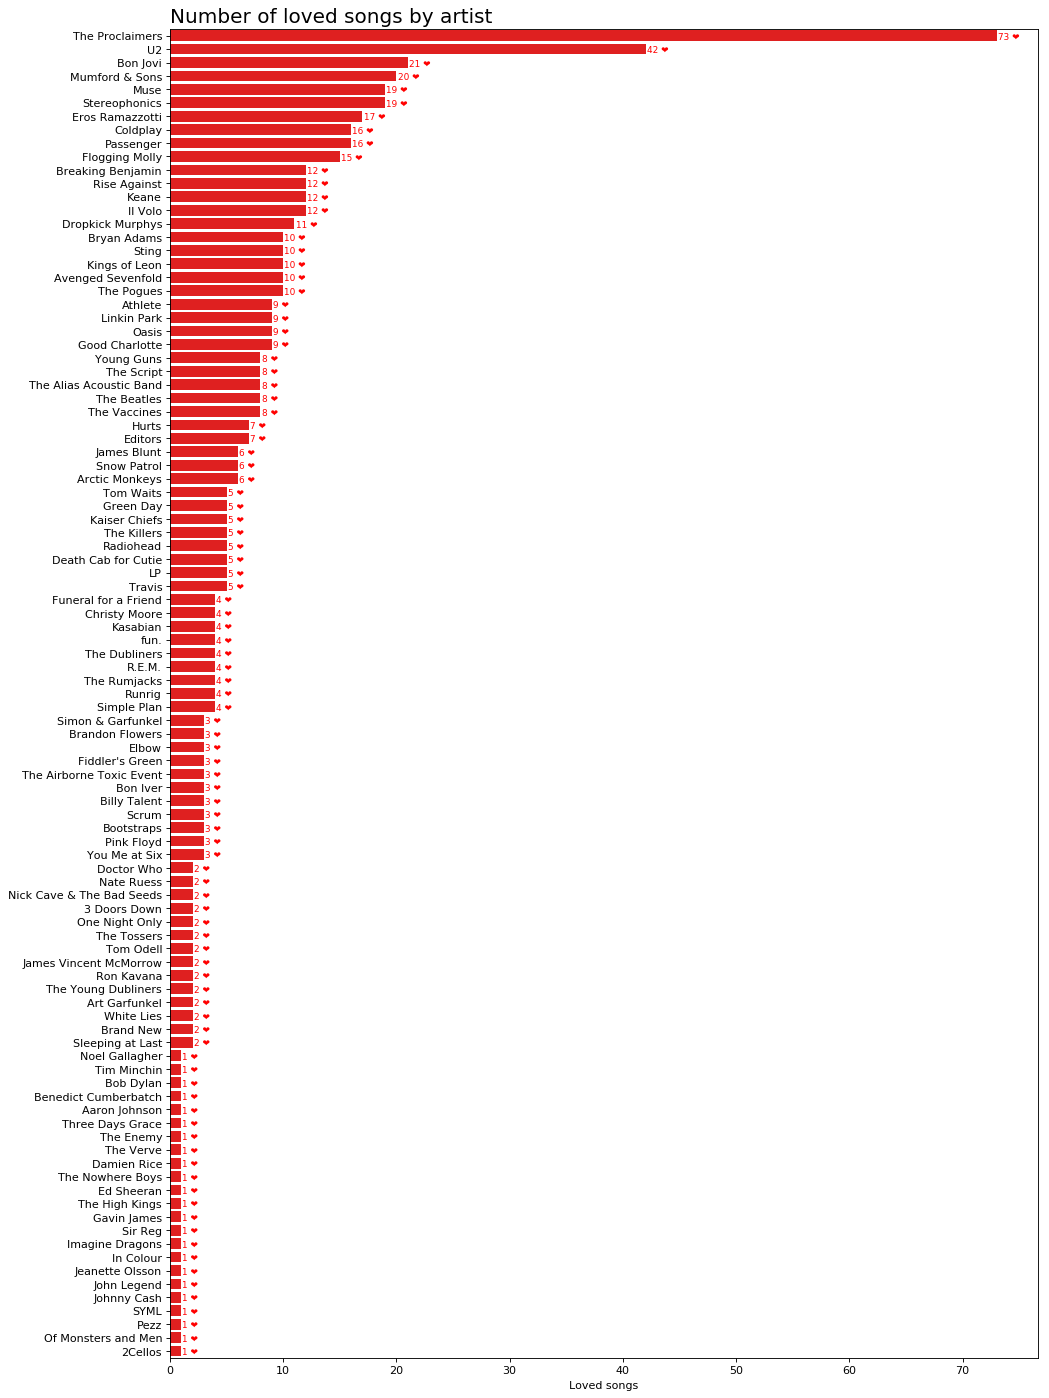

In [11]:
%matplotlib inline

loved_artists = loved.groupby("Artist").count().reset_index()[['Artist','Song']]
loved_artists.rename(columns={'Song':'Loved'}, inplace=True)
ladf = loved_artists.set_index(['Loved']).sort_index(ascending=True).reset_index()

palette = plt.get_cmap('Set1')
fig = plt.figure(figsize=(14, 22), dpi= 80, facecolor='w', edgecolor='k')  

ax = sns.barplot(x='Loved', y='Artist', data=ladf, order=reversed(ladf.Artist), color='r')
for i in list(range(len(ladf.index),0,-1)):
    plt.text(x=ladf.iloc[-i].Loved+0.1, y=i-0.75, s=str(ladf.iloc[-i].Loved)+' ❤️', size=8, color='r')
plt.title('Number of loved songs by artist', loc="left", fontsize=18)
plt.xlabel('Loved songs')
plt.ylabel('')
plt.show()



That's nice. Next, I want to visualize the dynamics of my scrobbles - i.e. how did the play count change for the top artist over time.

In [12]:
data['Year'] = data['DateTime'].dt.year
data['Month'] = data['DateTime'].dt.month
artists_months = data.groupby(['Artist','Year','Month']).count().reset_index()[['Artist','Year','Month','Song']]
artists_months.rename(columns={'Song': 'Scrobbles'}, inplace=True)
artists_months['Day'] = 1
artists_months['Date'] = pd.to_datetime(artists_months[['Year','Month','Day']])
amdf = artists_months[['Artist','Date','Scrobbles']]
pltstackdata = amdf[amdf.Artist.isin(asdf.Artist.head(6))]

A simple plot to show this.  

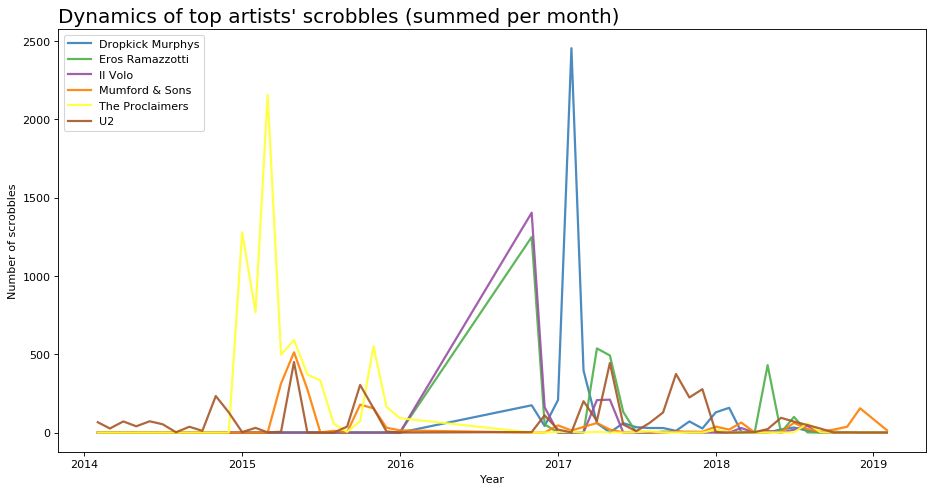

In [13]:
%matplotlib inline

psdf = pltstackdata.pivot(columns='Artist', values='Scrobbles', index='Date').fillna(0).reset_index()

palette = plt.get_cmap('Set1')
fig = plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')  
num=0
for column in psdf.drop('Date', axis=1):
    num+=1
    plt.plot(psdf['Date'], psdf[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)

plt.legend(loc=2, ncol=1)
plt.title("Dynamics of top artists' scrobbles (summed per month)", loc='left', fontsize=18)
plt.xlabel("Year")
plt.ylabel("Number of scrobbles")
plt.show()

While some activity peaks can be seen here (like that there were periods of time when I listened to The Proclaimers, Eros and Il Volo, or Dropkick Murphys quite a lot, whereas U2 and Mumford & Sons were more constant over time) not much data can be shown before the plot gets too noisy. I actually want a better, more interactive way to visualize this. And that totally calls for [plotly](https://plot.ly/python/).  

But first things first, arrange the data.

In [14]:
data['Date'] = data['DateTime'].dt.date
artists_days = data.groupby(['Date','Artist']).count().reset_index()[['Date','Artist','Song']]
artists_days.rename(columns={'Song': 'Scrobbles'}, inplace=True)
addf = pd.merge(artists_days, artists_scrobbles, on=['Artist'], how='outer')

And do some final filtering, in order for the plot not to be *too* noisy. And then also calculate some of the aesthetics to be used for plotting.

In [15]:
import numpy as np

# filtering for plot legibility
top_artists = sorted(addf[addf.ArtistScrobbles>100].Artist.drop_duplicates().get_values())
# scaling bubble size and opacity
max_artist_scrobbles = artists_scrobbles.ArtistScrobbles.max()
addf['MarkerSize']=np.log(addf.ArtistScrobbles)/np.log(1.4)
addf['MarkerOpacity']=np.log(addf.ArtistScrobbles)/np.log(addf.ArtistScrobbles).max()

In [16]:
%matplotlib inline

import plotly as py
import plotly.graph_objs as go

palette = plt.get_cmap('Set1')
fig = plt.figure(figsize=(14, 7), dpi= 80, facecolor='w', edgecolor='k')  
# setting colors for plot
N = len(top_artists)
c = ['hsl('+str(h)+',50%'+',50%)' for h in np.linspace(0, 360, N)]
# looping over data for each Artist, which is added to plot as a separate trace
l = []
for i in range(int(N)):
    ar = top_artists[i]
    da = addf[addf.Artist==ar]
    trace0 = go.Scatter(x=da['Date'], y=da['Scrobbles'], mode='markers', name=ar, 
                        marker=dict( color=c[i], size=da['MarkerSize'], opacity=da['MarkerOpacity']))
    l.append(trace0)
layout = go.Layout(title='My last.fm library', hovermode='closest',
                   xaxis= dict(title='Date', ticklen=5, zeroline=False, gridwidth=2),
                   yaxis=dict(title='Number of plays', ticklen=5, gridwidth=2), showlegend=True)
fig = go.Figure(data=l, layout=layout)
#py.offline.plot(fig)
py.plotly.plot(fig, filename='lastfm', auto_open=True)

'https://plot.ly/~anamariaelek/5'

In [17]:
#py.tools.set_credentials_file(username='anamariaelek', api_key='NIlED84QcigNnNIL8YJu')
#plotly.tools.set_config_file(world_readable=False,sharing='private')

While this might seem like an ovrekill at first, I find it rather cool. Each bubble on the plot is one artist played on that specific day, and it's y coordinate indicates the number of songs by this artist played on the given day (you see this also when hovering over each bubble). The size of the bubble is proportional to the total number of times I listened to this artist (but the values are $log_{1.4}$ transformed, to avoid ending up with bubbles of way too different sizes).  

First thing you'll likely notice is that I didn't scrobble almost any music in the period between February and October in 2016. It's not that I didn't actually listen to anything, I just didn't bother to sync whatever media devices I used at the time. Because, reasons. This put aside, I notice that in 2015 I extensively listened to Proclaimers and U2, in 2017 I had a phase when I was into italian music, therfore the peaks of Eros and Il Volo, and afterwards I was really into irish folk-rock stuff, with the likes of Dropkick Murphys, Flogging Molly and The Dubliners topping the charts there. Later on, it seems I listened to bits and pieces of everything. I think I'll zoom into the more recent period, say May 2018 till now, and inspect it better, because with plotly I can do that (just select it by click-and-dragging). 

If you turn on the compare mode here (find it on among options in the top right corner) you can see counts for different artists on hover. Brilliant. So yeah, I listened to a few different ones recently, but Arctic Monkeys stood out, followed by LP, then the Vaccines, and in the 2019 the Airborne Toxic Event. Oh yes, I love those guys - nice beat, amazing lyrics.  

Ok, I'll stop now. If that sparked your interest, you might want to inspect your own last.fm library in a similar way and maybe post some nice plots below in the comments. I'll put on some <span title="Afraid to love, afraid to lose; afraid to start, afraid to choose; afraid to live, afraid to die, afraid to let these days slip by; afraid to change or stay the same, afraid to lose yourself again. Afraid of this truth... that love could cause you so much pain.">[🎧🎵](https://youtu.be/g275QAyXbrA?t=101)</span> in the meantime.

# Resources

* The Python 3 [script](https://gist.github.com/anamariaelek/7d267871fd09ee7ee1380960fb83a732) for scrapping last.fm library (and the original Python 2 [version](https://gist.github.com/bitmorse/5201491)) can be downoladed from GitHub Gists.
* [Plotly](Plot.ly) provides amazing libraries for interactive visualization in Python, R and JavaScript.